<a href="https://colab.research.google.com/github/vpalani232/aai-iot-final/blob/main/predictive_maintenance_implementation_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IoT-Driven Predictive Maintenance for Industrial Machinery

This notebook implements a predictive maintenance solution using the **AI4I 2020 Predictive Maintenance Dataset**.

## Project Overview
1. **Task 1: Failure Mode Classification** - A Deep Neural Network (DNN) to classify the type of machine failure.
2. **Task 2: Tool Wear Prediction** - An LSTM network to forecast the progression of tool wear over time.

In [4]:
!pip install ucimlrepo
!pip install tensorflow

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 1. Load Dataset

In [6]:
print("Fetching dataset...")
ai4i_2020_predictive_maintenance_dataset = fetch_ucirepo(id=601)
X = ai4i_2020_predictive_maintenance_dataset.data.features
y = ai4i_2020_predictive_maintenance_dataset.data.targets

# Combine for EDA
df = pd.concat([X, y], axis=1)
df.head()

Fetching dataset...


,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


## 2. Exploratory Data Analysis (EDA)

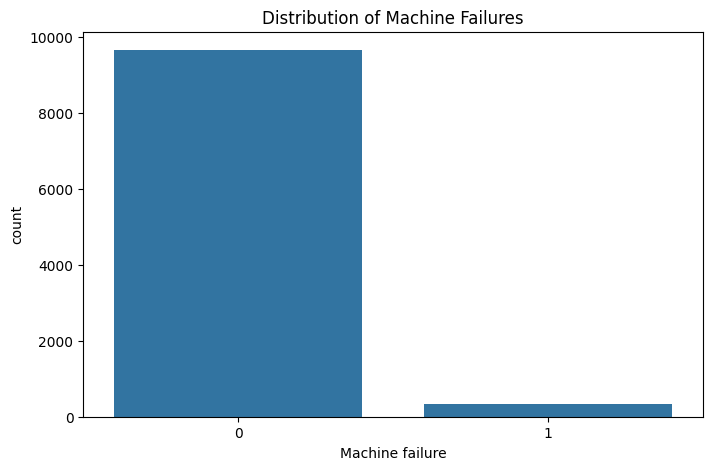

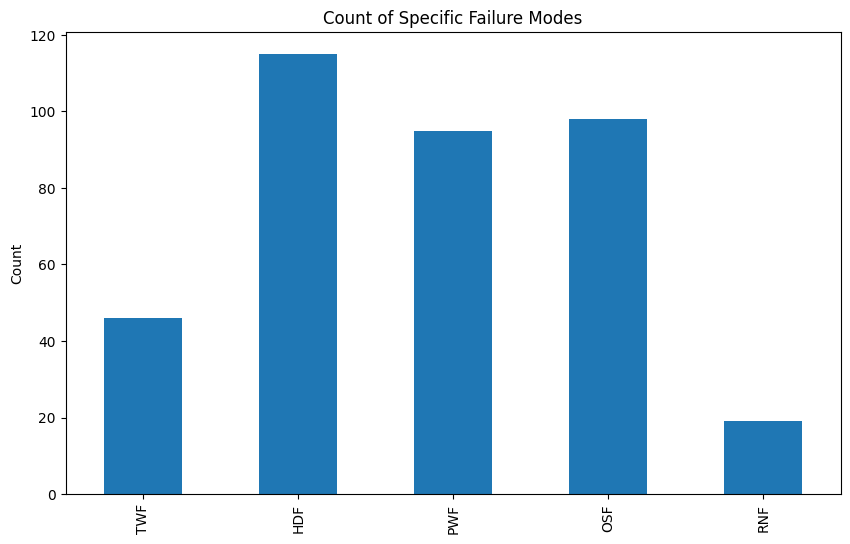

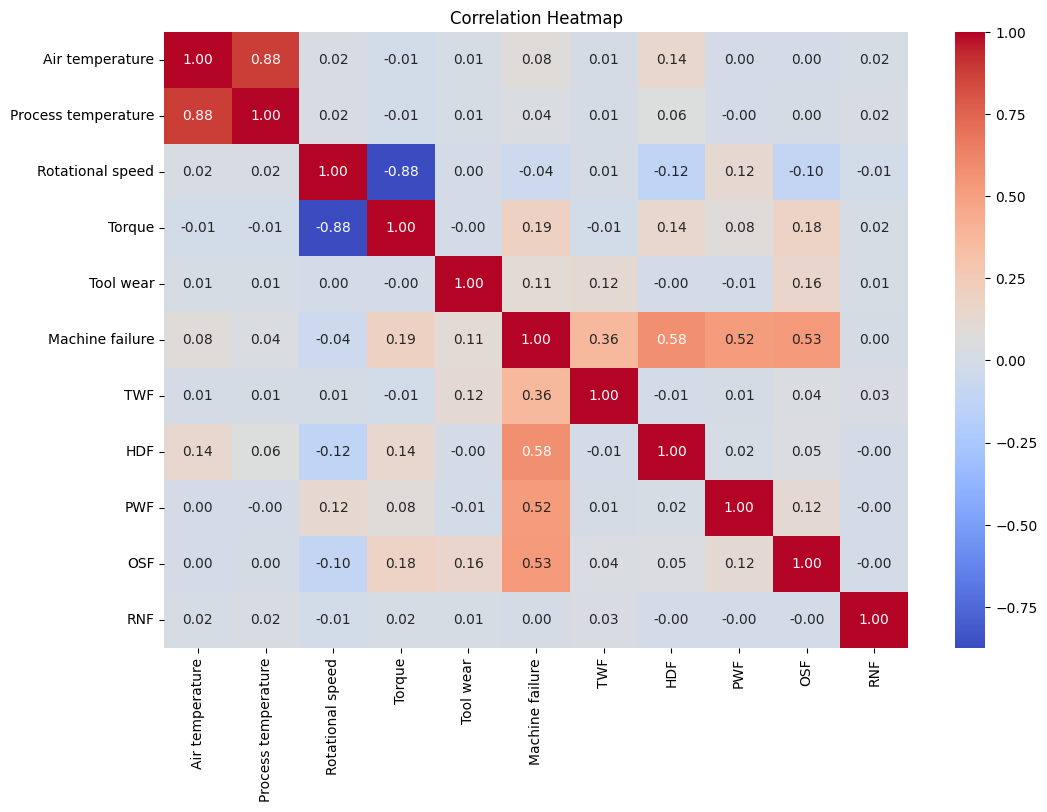

In [7]:
# Failure distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Machine failure', data=df)
plt.title('Distribution of Machine Failures')
plt.show()

# Specific failure modes
failure_modes = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
mode_counts = df[failure_modes].sum()
plt.figure(figsize=(10, 6))
mode_counts.plot(kind='bar')
plt.title('Count of Specific Failure Modes')
plt.ylabel('Count')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.drop(['Type'], axis=1).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## 3. Data Preprocessing

In [8]:
# Feature Engineering: Create 'Power' feature
df['Power'] = df['Rotational speed'] * df['Torque'] * (2 * np.pi / 60)

# Encode Product ID (Type)
le = LabelEncoder()
df['Type_Encoded'] = le.fit_transform(df['Type'])

# Define features for models
features = ['Type_Encoded', 'Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear', 'Power']

In [10]:
# Target for classification: Specific failure modes (0-5)
def get_failure_type(row):
    if row['TWF'] == 1: return 1
    if row['HDF'] == 1: return 2
    if row['PWF'] == 1: return 3
    if row['OSF'] == 1: return 4
    if row['RNF'] == 1: return 5
    return 0

df['Failure_Type'] = df.apply(get_failure_type, axis=1)
# Now calculate correlation
correlation_features = df[features + ['Failure_Type']].corr()
print("Correlation between Failure_Type and selected features:")
print(correlation_features['Failure_Type'].drop('Failure_Type'))

Correlation between Failure_Type and selected features:
Type_Encoded          -0.017423
Air temperature        0.057666
Process temperature    0.031192
Rotational speed      -0.041560
Torque                 0.196845
Tool wear              0.102114
Power                  0.186869
Name: Failure_Type, dtype: float64


## 4. Task 1: Deep Learning for Failure Mode Classification (DNN)

In [11]:
X_clf = df[features]
y_clf = df['Failure_Type']

# Split and Scale
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, stratify=y_clf, random_state=42)
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

# Build DNN from scratch
dnn_model = Sequential([
    Input(shape=(X_train_clf_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

dnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train DNN
history_dnn = dnn_model.fit(X_train_clf_scaled, y_train_clf, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate DNN
y_pred_clf = np.argmax(dnn_model.predict(X_test_clf_scaled), axis=1)
print(classification_report(y_test_clf, y_pred_clf))

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8463 - loss: 0.7518 - val_accuracy: 0.9600 - val_loss: 0.2451
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9664 - loss: 0.2126 - val_accuracy: 0.9600 - val_loss: 0.1903
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9665 - loss: 0.1701 - val_accuracy: 0.9613 - val_loss: 0.1674
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9666 - loss: 0.1554 - val_accuracy: 0.9625 - val_loss: 0.1515
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9649 - loss: 0.1442 - val_accuracy: 0.9625 - val_loss: 0.1390
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9675 - loss: 0.1289 - val_accuracy: 0.9663 - val_loss: 0.1334
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9667 - loss: 0.1281 - val_accuracy: 0.9675 - val_loss: 0.1234
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9691 - loss: 0.1198 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 5. Task 2: Time Series Prediction for Tool Wear (LSTM)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.5161 - val_loss: 0.1403
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1755 - val_loss: 0.1228
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1598 - val_loss: 0.1203
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1617 - val_loss: 0.1173
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1558 - val_loss: 0.1151
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1497 - val_loss: 0.1136
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1552 - val_loss: 0.1125
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1440 - val_loss: 0.1140
Epoch 9/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1515 - val_loss: 0.1158
Epoch 10/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1454 - val_loss: 0.1147
Epoch 11/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1443 - val_loss: 0.1145
Epoch 12/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/s

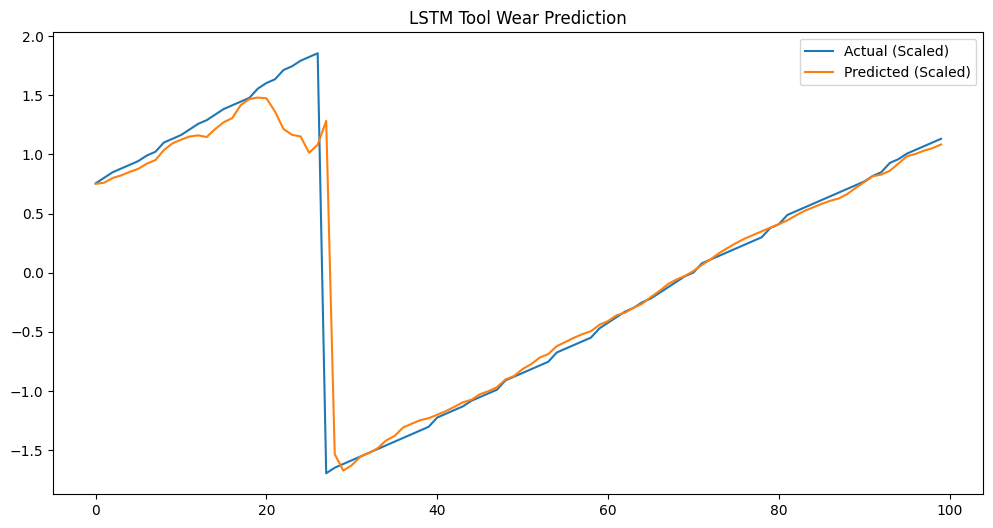

In [9]:
# Window size for time series
window_size = 10

def create_sequences(data, target, window):
    X_seq, y_seq = [], []
    for i in range(len(data) - window):
        X_seq.append(data[i:i+window])
        y_seq.append(target[i+window])
    return np.array(X_seq), np.array(y_seq)

# Scale all features for LSTM
scaler_ts = StandardScaler()
df_scaled = scaler_ts.fit_transform(df[features])
target_col_idx = features.index('Tool wear')
target_scaled = df_scaled[:, target_col_idx]

X_ts, y_ts = create_sequences(df_scaled, target_scaled, window_size)

# Temporal split
split_idx = int(len(X_ts) * 0.8)
X_train_ts, X_test_ts = X_ts[:split_idx], X_ts[split_idx:]
y_train_ts, y_test_ts = y_ts[:split_idx], y_ts[split_idx:]

# Build LSTM from scratch
lstm_model = Sequential([
    Input(shape=(window_size, len(features))),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Train LSTM
history_lstm = lstm_model.fit(X_train_ts, y_train_ts, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate LSTM
y_pred_ts = lstm_model.predict(X_test_ts)
rmse = np.sqrt(mean_squared_error(y_test_ts, y_pred_ts))
print(f"LSTM Prediction RMSE (Scaled): {rmse}")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_test_ts[:100], label='Actual (Scaled)')
plt.plot(y_pred_ts[:100], label='Predicted (Scaled)')
plt.title('LSTM Tool Wear Prediction')
plt.legend()
plt.show()